In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

In [39]:
train_data = datasets.MNIST(root='D:/python/深度学习/data', train=True, transform=transform, download=False)

test_data = datasets.MNIST(root='D:/python/深度学习/data', train=False, transform=transform, download=False)

In [40]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [41]:
class ResidualBlock(nn.Module):
    def __init__(self, channel):
        super(ResidualBlock, self).__init__()
        self.channel = channel
        self.conv1 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x + y)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pooling = nn.MaxPool2d(2)

        self.rblock1 = ResidualBlock(16)
        self.rblock2 = ResidualBlock(32)

        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pooling(F.relu(self.conv1(x)))
        x = self.rblock1(x)
        x = self.pooling(F.relu(self.conv2(x)))
        x = self.rblock2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [43]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device=device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rblock1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rblock2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [44]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [45]:
for epoch in range(100):
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target.long())
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 300 == 0:
             print(f'Epoch [{epoch + 1}/{100}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/100], Step [300/938], Loss: 0.0955
Epoch [1/100], Step [600/938], Loss: 0.2081
Epoch [1/100], Step [900/938], Loss: 0.2576
Epoch [2/100], Step [300/938], Loss: 0.1415
Epoch [2/100], Step [600/938], Loss: 0.1387
Epoch [2/100], Step [900/938], Loss: 0.0901
Epoch [3/100], Step [300/938], Loss: 0.0710
Epoch [3/100], Step [600/938], Loss: 0.0732
Epoch [3/100], Step [900/938], Loss: 0.0528
Epoch [4/100], Step [300/938], Loss: 0.0067
Epoch [4/100], Step [600/938], Loss: 0.0202
Epoch [4/100], Step [900/938], Loss: 0.0166
Epoch [5/100], Step [300/938], Loss: 0.0268
Epoch [5/100], Step [600/938], Loss: 0.0197
Epoch [5/100], Step [900/938], Loss: 0.0170
Epoch [6/100], Step [300/938], Loss: 0.0065
Epoch [6/100], Step [600/938], Loss: 0.0066
Epoch [6/100], Step [900/938], Loss: 0.0124
Epoch [7/100], Step [300/938], Loss: 0.0070
Epoch [7/100], Step [600/938], Loss: 0.0136
Epoch [7/100], Step [900/938], Loss: 0.0277
Epoch [8/100], Step [300/938], Loss: 0.0114
Epoch [8/100], Step [600/938], L

In [47]:
correct = 0  
total = 0  
Accuracy = []
with torch.no_grad():   
    for data, (inputs, target) in enumerate(test_loader):  
        inputs, target = inputs.to(device), target.to(device)
        outputs = model(inputs)  
        _, predicted = torch.max(outputs.data, 1)  
        total += target.size(0)  
        correct += (predicted == target).sum().item()  
        Accuracy.append(f"{100 * correct / total:.2f}")
print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 99.02%


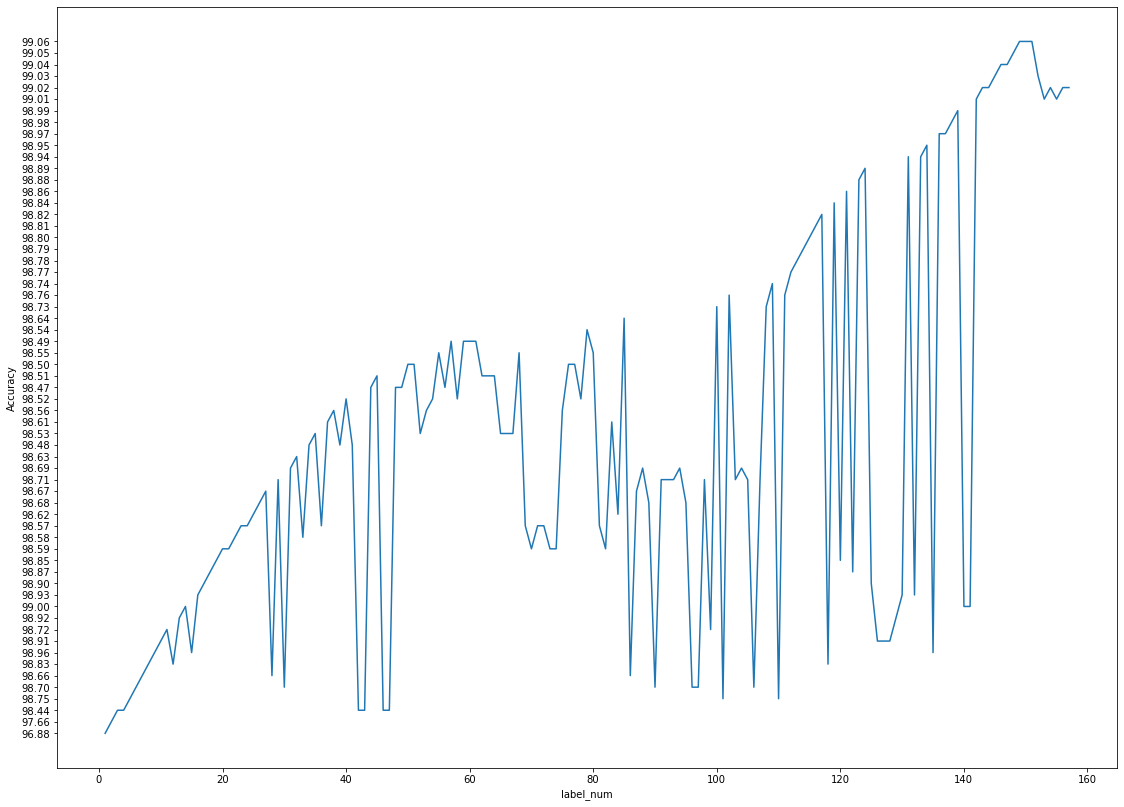

In [49]:
plt.figure(figsize=(19, 14))
plt.plot(range(1, len(Accuracy) + 1), Accuracy)
plt.xlabel("label_num")
plt.ylabel("Accuracy")
plt.show()